In [ ]:
import numpy as np
from pandas import read_csv
from keras.models import Sequential
import pandas as pd
from keras.layers import Conv1D,MaxPooling1D,Dense,Flatten,Dropout,LSTM,Bidirectional

from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from keras.utils import plot_model
import keras
import zipfile
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
# set seed to reproduce similar results
np.random.seed(0)

In [ ]:

!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
dataset_file_id = '1xnD6OXIMNOChR4V9DKO-Jjsb7QNMUjc0'

In [ ]:
downloaded = drive.CreateFile({'id':dataset_file_id})
downloaded.GetContentFile('UCI HAR Dataset.zip')

In [ ]:
!unzip "/content/UCI HAR Dataset.zip" -d "/content/"


Archive:  /content/UCI HAR Dataset.zip
   creating: /content/UCI HAR Dataset/
  inflating: /content/UCI HAR Dataset/.DS_Store  
   creating: /content/__MACOSX/
   creating: /content/__MACOSX/UCI HAR Dataset/
  inflating: /content/__MACOSX/UCI HAR Dataset/._.DS_Store  
  inflating: /content/UCI HAR Dataset/activity_labels.txt  
  inflating: /content/__MACOSX/UCI HAR Dataset/._activity_labels.txt  
  inflating: /content/UCI HAR Dataset/features.txt  
  inflating: /content/__MACOSX/UCI HAR Dataset/._features.txt  
  inflating: /content/UCI HAR Dataset/features_info.txt  
  inflating: /content/__MACOSX/UCI HAR Dataset/._features_info.txt  
  inflating: /content/UCI HAR Dataset/README.txt  
  inflating: /content/__MACOSX/UCI HAR Dataset/._README.txt  
   creating: /content/UCI HAR Dataset/test/
   creating: /content/UCI HAR Dataset/test/Inertial Signals/
  inflating: /content/UCI HAR Dataset/test/Inertial Signals/body_acc_x_test.txt  
   creating: /content/__MACOSX/UCI HAR Dataset/test/
   

In [ ]:
features_df = pd.read_csv('/content/UCI HAR Dataset/features.txt',sep="\s+",
                         header=None, names=["column_index", "column_name"])

feature_names = features_df["column_name"].values.tolist()


In [ ]:
path = "/content/UCI HAR Dataset/"

X_train = pd.read_csv(path+"train/X_train.txt",sep="\s+", header = None)
X_train.columns = feature_names
X_test = pd.read_csv(path+"test/X_test.txt",sep="\s+", header = None)
X_test.columns = feature_names
y_train = pd.read_csv(path+"train/y_train.txt",sep="\s+", header = None)
y_train.columns = ['action']
y_test = pd.read_csv(path+"test/y_test.txt",sep="\s+", header = None)
y_test.columns = ['action']



In [ ]:
batch_size = 64
validation_split = 0.2

In [ ]:
def split_sequences(sequences, n_steps):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the dataset
		if end_ix > len(sequences):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)


In [ ]:
y_train_array = np.array(y_train)
train_set = np.c_[X_train, y_train_array]

y_test_array = np.array(y_test)
test_set = np.c_[X_test, y_test_array]

In [ ]:
X_train, y_train = split_sequences(train_set, 3)
print(X_train.shape, y_train.shape)

X_test, y_test = split_sequences(test_set, 3)
print(X_test.shape, y_test.shape)


(7350, 3, 561) (7350,)
(2945, 3, 561) (2945,)


In [ ]:
y_train = to_categorical(y_train)
print(y_train.shape)
y_test = to_categorical(y_test)
print(y_test.shape)


(7350, 7)
(2945, 7)


In [ ]:
n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train.shape[1]
print(n_timesteps, n_features, n_outputs)


3 561 7


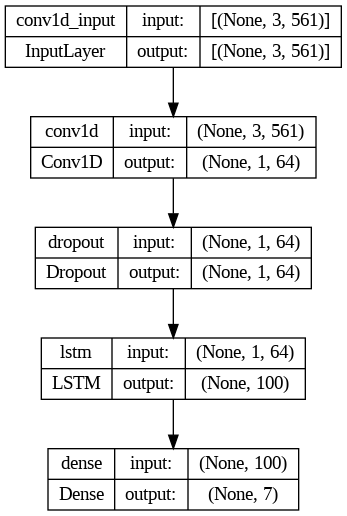

In [ ]:
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
model.add(Dropout(0.5))
model.add(LSTM(100, activation='relu'))
model.add(Dense(7, activation='softmax'))
plot_model(model, show_shapes=True, show_layer_names=True)

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# fit network
train_epochs = 20
history = model.fit(X_train, y_train, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_split=validation_split, shuffle=True)

Epoch 1/20
92/92 [==============================] - 5s 21ms/step - loss: 1.0906 - accuracy: 0.5134 - val_loss: 0.4688 - val_accuracy: 0.8333
Epoch 2/20
92/92 [==============================] - 1s 10ms/step - loss: 0.5436 - accuracy: 0.7719 - val_loss: 0.2985 - val_accuracy: 0.9170
Epoch 3/20
92/92 [==============================] - 1s 10ms/step - loss: 0.3873 - accuracy: 0.8325 - val_loss: 0.2308 - val_accuracy: 0.9061
Epoch 4/20
92/92 [==============================] - 1s 10ms/step - loss: 0.3247 - accuracy: 0.8643 - val_loss: 0.1936 - val_accuracy: 0.9327
Epoch 5/20
92/92 [==============================] - 1s 9ms/step - loss: 0.2697 - accuracy: 0.8912 - val_loss: 0.1987 - val_accuracy: 0.9177
Epoch 6/20
92/92 [==============================] - 1s 9ms/step - loss: 0.2302 - accuracy: 0.9049 - val_loss: 0.1860 - val_accuracy: 0.9306
Epoch 7/20
92/92 [==============================] - 1s 9ms/step - loss: 0.2120 - accuracy: 0.9153 - val_loss: 0.1424 - val_accuracy: 0.9327
Epoch 8/20
92/92

In [ ]:
# evaluate model
test_loss, test_accuracy = model.evaluate(X_test, y_test, batch_size=batch_size, verbose=0)
print("Accuracy", test_accuracy)

Accuracy of the CNN model 0.9463497400283813
93/93 [==============================] - 1s 2ms/step
